In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag, map_tag
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [2]:
pf_df = pd.read_csv('kaggle_poem_dataset.csv')
pf_df['Author'] = pf_df.Author.astype('category')
pf_df.columns = [name.lower() for name in pf_df.columns]
pf_df = pf_df.drop(['unnamed: 0', 'poetry foundation id'], axis=1)
pf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15652 entries, 0 to 15651
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   author   15652 non-null  category
 1   title    15652 non-null  object  
 2   content  15652 non-null  object  
dtypes: category(1), object(2)
memory usage: 430.2+ KB


In [3]:
# create function to clean lines
import string, re
from nltk.corpus import words
import multiprocessing as mp
def clean_text(text):
    text = text.lower()
    text = re.sub(' +', ' ', text)
    text = text.replace('\%','')
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    tokens = text.split()
    text = " ".join(filter(lambda x:x[0]!="@", tokens))
    text = " ".join([s.strip(string.punctuation) for s in tokens])
    text = text.encode("ascii", "ignore").decode()
    return text.strip()

def clean_list(list_of_strings):
    return [clean_text(string) for string in list_of_strings if string]

In [4]:
test_string = "-093h4t6-o it#%^34 -tdfgh^0897-q .....ele 13"
test_list = ['this -09shv-09hga asldknzvi a line ..a,y4990']*4
test_list = [item.split() for item in test_list]
print(clean_text(test_string))
# print(pd.Series(test_list).map(clean_list))

ele


In [5]:
# create column to store document as list of lines
# import multiprocessing as mp

pf_df['line'] = pf_df.content.str.split('\n')
# with mp.Pool(processes=mp.cpu_count()-1) as pool:
#     clean_lines = pool.map(clean_list, pf_df.line)
pf_df['line'] = pf_df['line'].map(clean_list)
# pf_df['line'] = clean_lines
print(pf_df.iloc[0])

author                                        Wendy Videlock
title                                                      !
content    Dear Writers, I’m compiling the first in what ...
line       [dear writers im compiling the first in what i...
Name: 0, dtype: object


In [6]:
# construct function to remove empty lines for accurate line count
def remove_empty_lines(list_of_lines):
    try:
        return [i for i in list_of_lines if i]
    except TypeError:
        return pd.NA
    
pf_df['line'] = pf_df.line.map(remove_empty_lines)
print(pf_df.iloc[0])

author                                        Wendy Videlock
title                                                      !
content    Dear Writers, I’m compiling the first in what ...
line       [dear writers im compiling the first in what i...
Name: 0, dtype: object


In [7]:
# create column for length of poem in lines
pf_df['length_in_lines'] = pf_df.line.map(len)
pf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15652 entries, 0 to 15651
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   author           15652 non-null  category
 1   title            15652 non-null  object  
 2   content          15652 non-null  object  
 3   line             15652 non-null  object  
 4   length_in_lines  15652 non-null  int64   
dtypes: category(1), int64(1), object(3)
memory usage: 674.7+ KB


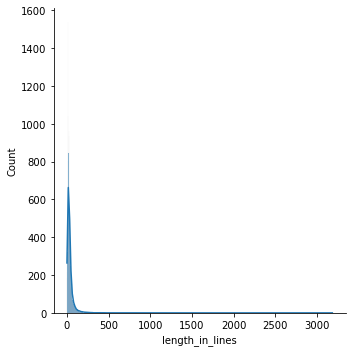

In [8]:
sns.displot(pf_df.length_in_lines, kde=True)

In [9]:
# filtering outliers with zscore
from scipy import stats
clean_df = pf_df[(np.abs(stats.zscore(pf_df.length_in_lines)) < 2)]

In [10]:
# filter sub-haiku length works
clean_df = clean_df[clean_df.length_in_lines > 2]

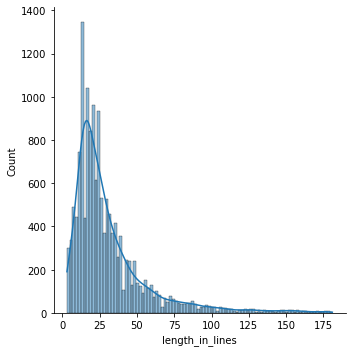

In [11]:
sns.displot(clean_df.length_in_lines, kde=True)

In [12]:
def lexical_diversity(line_list):
    doc_string = ' '.join(line_list)
    words = word_tokenize(doc_string)
    return (len(set(words))/len(words))
        
clean_df['lexical_diversity'] = clean_df.line.map(lexical_diversity)

In [13]:
clean_df.line.head()

1    [philosophic, in its complex ovoid emptiness, ...
2    [wed like to talk with you about fear they sai...
3    [the wise men will unlearn your name, above yo...
4    [for jack collom, things i do every day, play ...
5    [winter, more time is spent at the window, sum...
Name: line, dtype: object

In [14]:
def lines2words(list_of_lines):
    text = list_of_lines
    while not isinstance(text, str):
        try:
            text = ' '.join(text)
        except TypeError:
            try:
                   text = ' '.join([item for sublist in text for item in sublist])
            except:
                print(f"problem with {text}")
    return text.split()

# test_list = ['this is a line']*4
# clean_df['line'].sample(n=2).map(lines2words)
# print(test_list)
# print(lines2words(test_list))

In [15]:
poems_corpus = clean_df.line.map(lines2words)
clean_df['words'] = poems_corpus

In [16]:
clean_df.head()

,author,title,content,line,length_in_lines,lexical_diversity,words
1,Hailey Leithauser,0,"Philosophic\nin its complex, ovoid emptiness,\...","[philosophic, in its complex ovoid emptiness, ...",15,0.863636,"[philosophic, in, its, complex, ovoid, emptine..."
2,Jody Gladding,1-800-FEAR,We'd like to talk with you about fear t...,[wed like to talk with you about fear they sai...,11,0.663717,"[wed, like, to, talk, with, you, about, fear, ..."
3,Joseph Brodsky,1 January 1965,The Wise Men will unlearn your name.\nAbove yo...,"[the wise men will unlearn your name, above yo...",24,0.693333,"[the, wise, men, will, unlearn, your, name, ab..."
4,Ted Berrigan,3 Pages,For Jack Collom\n10 Things I do Every Day\n\np...,"[for jack collom, things i do every day, play ...",26,0.846154,"[for, jack, collom, things, i, do, every, day,..."
5,Joe Brainard,30 One-Liners,WINTER\nMore time is spent at the window.\n\nS...,"[winter, more time is spent at the window, sum...",65,0.575843,"[winter, more, time, is, spent, at, the, windo..."


In [17]:
with open('poem_corpus.pkl', 'wb') as f:
    pickle.dump(poems_corpus, f)

In [18]:
with open('clean_df.pkl', 'wb') as f:
    pickle.dump(clean_df, f)

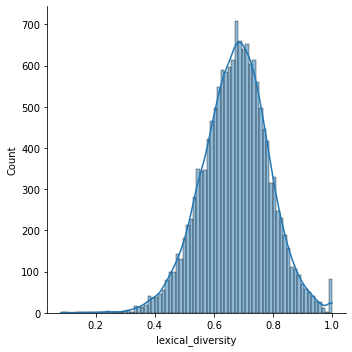

In [19]:
sns.displot(clean_df.lexical_diversity, kde=True)

In [20]:
clean_df.info()
# sample 3 lines from each poem
# import random
# clean_df.line.describe()
# docs_in_lines = clean_df.line.to_list()
# line_samples = [random.sample(lines,3) for lines in docs_in_lines]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15076 entries, 1 to 15651
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   author             15076 non-null  category
 1   title              15076 non-null  object  
 2   content            15076 non-null  object  
 3   line               15076 non-null  object  
 4   length_in_lines    15076 non-null  int64   
 5   lexical_diversity  15076 non-null  float64 
 6   words              15076 non-null  object  
dtypes: category(1), float64(1), int64(1), object(4)
memory usage: 1008.8+ KB


In [21]:
line_df = clean_df.explode('line').drop(['length_in_lines', 'content','lexical_diversity'],axis=1)
line_df.reset_index(drop=True)

,author,title,line,words
0,Hailey Leithauser,0,philosophic,"[philosophic, in, its, complex, ovoid, emptine..."
1,Hailey Leithauser,0,in its complex ovoid emptiness,"[philosophic, in, its, complex, ovoid, emptine..."
2,Hailey Leithauser,0,a skillful pundit coined it as a sort,"[philosophic, in, its, complex, ovoid, emptine..."
3,Hailey Leithauser,0,of stopgap doorstop for those,"[philosophic, in, its, complex, ovoid, emptine..."
4,Hailey Leithauser,0,quaint equations,"[philosophic, in, its, complex, ovoid, emptine..."
...,...,...,...,...
471431,Joseph O. Legaspi,Your Mother Wears a House Dress,for thirst,"[if, your, house, is, a, dress, itll, fit, lik..."
471432,Joseph O. Legaspi,Your Mother Wears a House Dress,cloaked as,"[if, your, house, is, a, dress, itll, fit, lik..."
471433,Joseph O. Legaspi,Your Mother Wears a House Dress,he is warm,"[if, your, house, is, a, dress, itll, fit, lik..."
471434,Joseph O. Legaspi,Your Mother Wears a House Dress,radiant in a,"[if, your, house, is, a, dress, itll, fit, lik..."


In [22]:
line_df['line_no'] = line_df.groupby(['author',"title"]).cumcount()+1

In [23]:
line_df.head()

,author,title,line,words,line_no
1,Hailey Leithauser,0,philosophic,"[philosophic, in, its, complex, ovoid, emptine...",1
1,Hailey Leithauser,0,in its complex ovoid emptiness,"[philosophic, in, its, complex, ovoid, emptine...",2
1,Hailey Leithauser,0,a skillful pundit coined it as a sort,"[philosophic, in, its, complex, ovoid, emptine...",3
1,Hailey Leithauser,0,of stopgap doorstop for those,"[philosophic, in, its, complex, ovoid, emptine...",4
1,Hailey Leithauser,0,quaint equations,"[philosophic, in, its, complex, ovoid, emptine...",5


In [24]:
line_df['words'] = line_df.line.map(word_tokenize)
line_df.head()

,author,title,line,words,line_no
1,Hailey Leithauser,0,philosophic,[philosophic],1
1,Hailey Leithauser,0,in its complex ovoid emptiness,"[in, its, complex, ovoid, emptiness]",2
1,Hailey Leithauser,0,a skillful pundit coined it as a sort,"[a, skillful, pundit, coined, it, as, a, sort]",3
1,Hailey Leithauser,0,of stopgap doorstop for those,"[of, stopgap, doorstop, for, those]",4
1,Hailey Leithauser,0,quaint equations,"[quaint, equations]",5


In [25]:
line_df['length_in_words'] = line_df.words.map(len)

In [26]:
line_df.describe()

,line_no,length_in_words
count,471436.000000,471436.000000
mean,27.398315,6.839384
std,27.854321,5.715644
min,1.000000,1.000000
25%,8.000000,5.000000
50%,18.000000,7.000000
75%,36.000000,8.000000
max,181.000000,606.000000


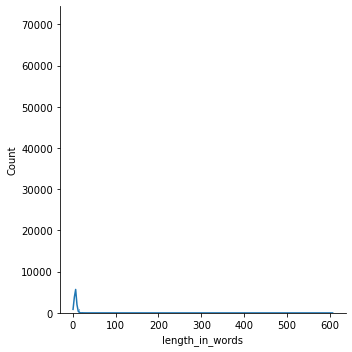

In [27]:
x = line_df.length_in_words
sns.displot(data=line_df, x='length_in_words', kde=True)

In [28]:
# filtering outliers with zscore
from scipy import stats
clean_line_df = line_df[(np.abs(stats.zscore(line_df.length_in_words)) < 2)]

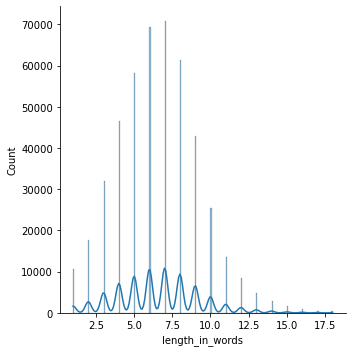

In [29]:
# fig, ax = plt.subplots()
# x = clean_line_df.length_in_words
sns.displot(data=clean_line_df, x='length_in_words', kde=True)
# plt.tight_layout()

In [30]:
line_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471436 entries, 1 to 15651
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   author           471436 non-null  category
 1   title            471436 non-null  object  
 2   line             471436 non-null  object  
 3   words            471436 non-null  object  
 4   line_no          471436 non-null  int64   
 5   length_in_words  471436 non-null  int64   
dtypes: category(1), int64(2), object(3)
memory usage: 22.6+ MB


In [31]:
clean_line_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468222 entries, 1 to 15651
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   author           468222 non-null  category
 1   title            468222 non-null  object  
 2   line             468222 non-null  object  
 3   words            468222 non-null  object  
 4   line_no          468222 non-null  int64   
 5   length_in_words  468222 non-null  int64   
dtypes: category(1), int64(2), object(3)
memory usage: 22.5+ MB


In [32]:
clean_line_df['lexical_diversity'] = clean_line_df.words.map(lexical_diversity)

<ipython-input-32-5b05ab53e382>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_line_df['lexical_diversity'] = clean_line_df.words.map(lexical_diversity)


In [33]:
clean_line_df.head()
with open('clean_line_df.pkl', 'wb') as f:
    pickle.dump(clean_line_df, f)

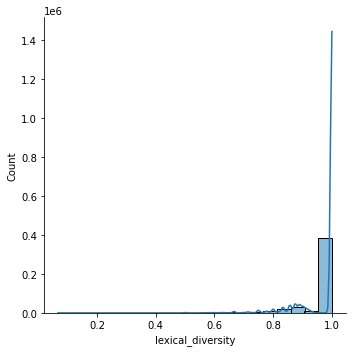

In [34]:
sns.displot(data=clean_line_df, x="lexical_diversity", kde=True)

In [35]:
author_line_lexical = clean_line_df.drop(['title','line','words'], axis=1).groupby('author').mean()

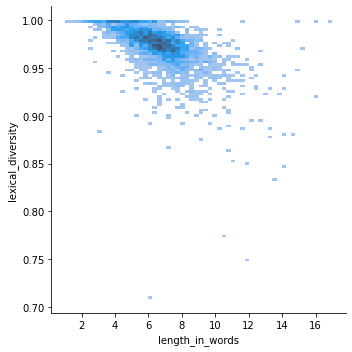

In [36]:
author_line_lexical.reset_index(inplace=True)
sns.displot(data=author_line_lexical, x='length_in_words',y='lexical_diversity')

In [37]:
author_line_lexical.describe()

,line_no,length_in_words,lexical_diversity
count,3245.000000,3245.000000,3245.000000
mean,18.350725,6.652476,0.973111
std,12.749815,1.748223,0.020252
min,1.000000,1.000000,0.708333
25%,9.500000,5.571429,0.964770
50%,14.424779,6.614420,0.976190
75%,23.390244,7.617716,0.985679
max,90.500000,17.000000,1.000000


In [38]:
# author_line_lexical_mode = clean_line_df.drop(['title','line','words'], axis=1).groupby('author').mode()
# author_line_lexical_mode.reset_index(inplace=True)
# sns.displot(data=author_line_lexical_avg, x='length_in_words',y='lexical_diversity')

In [39]:
clean_line_df.head()

,author,title,line,words,line_no,length_in_words,lexical_diversity
1,Hailey Leithauser,0,philosophic,[philosophic],1,1,1.000
1,Hailey Leithauser,0,in its complex ovoid emptiness,"[in, its, complex, ovoid, emptiness]",2,5,1.000
1,Hailey Leithauser,0,a skillful pundit coined it as a sort,"[a, skillful, pundit, coined, it, as, a, sort]",3,8,0.875
1,Hailey Leithauser,0,of stopgap doorstop for those,"[of, stopgap, doorstop, for, those]",4,5,1.000
1,Hailey Leithauser,0,quaint equations,"[quaint, equations]",5,2,1.000
